# Counts Matrix QC and Normalisation

## Table of contents  
0. [Background](#background)
1. [Ambient RNA correction](#rna_correction)
2. [Reading data](#reading_data)
3. [Gene annotation](#gene_annotation)
4. [Filtering](#filtering)
5. [Normalisation](#normalisation)
6. [Pre-processing workflow](#workflow)

## 0. Background

### Data

We are working with data from [Caron et al. 2020](https://doi.org/10.1038/s41598-020-64929-x), investigating the transcriptional profile of different types of childhood acute lymphoblastic leukemia (ALL). 
There are different subtypes of ALL, with the two main groups being B-cell lymphoblastic leukemia (affecting immature B-cell lymphocytes) and T-cell lymphoblastic leukemia (affecting immature T-cell lymphocytes). 
Within each of these broad types, there are further classifications based on commonly observed genetic changes such as large chromosomal rearragements. 

In this dataset ([SRA Accession PRJNA548203](https://www.ncbi.nlm.nih.gov/bioproject/?term=PRJNA548203)), we have 4 groups of samples: 

* `ETV6-RUNX1` (4 replicates): samples from a type of B-cell precursor ALL characterised by a translocation between chromosomes 12 and 21 known as the _t(12;21) ETV6/RUNX1_ rearrangement.
* `HHD` (2 replicates): also a type of B-cell precursor ALL, where extra chromosomes are gained and known as the "high hyper diploid" type.
* `PRE-T` (2 replicates): a type of T-cell precursor ALL.
* `PBMMC` (3 replicates): control samples from healthy pediatric bone marrow mononuclear cells.

We will start by showing how to read and preprocessing the data for one of these samples only. 
We will then show how to apply the preprocessing to all samples, after which we integrate them together taking into account batch effects inherent to these type of data. 

### Setting up

In [1]:
import os
from glob import glob
import numpy as np
from scipy.stats import median_abs_deviation
from scipy.sparse import csr_matrix
import pandas as pd
import scanpy as sc
import anndata as ad
import pybiomart as bm
import seaborn as sns

# set plotting theme
sns.set_theme()

<a id="rna_correction"></a>
## 1. Ambient RNA correction

We remove ambient RNA from the dataset, typically using the raw dataset with empty droplets.  In our example here, we use CellBender, currently one the best tools for ambient RNA correction.  However, because of VM and time limitations, we will not run this step.  To give you an idea of runtime, the PBMC 10k dataset on a server with 12 cores and 96 GB RAM takes about five hours, [according to this CellRanger post](https://www.10xgenomics.com/analysis-guides/background-removal-guidance-for-single-cell-gene-expression-datasets-using-third-party-tools).  It can be made much faster with CUDA GPU using the `--cuda` argument, if CUDA GPU is available.


First, we create an anndata h5ad file from the raw CellRagner output.  In this example, let us use one of the replicates of the ETV6/RUNX1 subtype.  The block of code below is written in a raw cell (not a code cell), to prevent you from accidentally running this step.

We then go to a bash terminal to run CellBender.  CellBender usage is described [here](https://cellbender.readthedocs.io/en/latest/usage/index.html).  In this example, Cellbender is run using the official, GPU-enabled docker image available from the Google Container Registry (GCR) (see [Github page](https://github.com/broadinstitute/CellBender)):

`us.gcr.io/broad-dsde-methods/cellbender:latest`  

Several outputs will be written, but the main outputs will be named `$PREFIX_OUTPUTS/cellbender/SRR9264343.denoised.h5` and `$PREFIX_OUTPUTS/cellbender/SRR9264343.denoised_filtered.h5`.

<a id="reading_data"></a>
## 2. Reading data

As we do not run CellBender in this demo, we use the filtered outputs of CellRanger, instead.  We start by reading the data using one of the read functions from `scanpy` ([documented here](https://scanpy.readthedocs.io/en/stable/api/reading.html)). In our case, we have our data as [matrices from CellRanger](https://www.10xgenomics.com/support/software/cell-ranger/latest/analysis/outputs/cr-outputs-mex-matrices), so we use the function `sc.read_10x_mtx()`, which takes a directory as its input.  

We read one of the replicates of the ETV6/RUNX1 subtype:  

In [2]:
# These paths are specific to this demo only, where root is the root of the course materials repo.
# You may specify your specific input and output directories when recreating this in your local machine or HPC.
prefix_inputs = "../Data/CellRanger_Outputs"
prefix_outputs = "../Data/results/04_05"

os.makedirs(prefix_outputs)

ETV6_RUNX1_1 = sc.read_10x_mtx(f"{prefix_inputs}/SRR9264343/outs/filtered_feature_bc_matrix/")

In [3]:
ETV6_RUNX1_1

AnnData object with n_obs × n_vars = 3153 × 37764
    var: 'gene_ids', 'feature_types'

This object stores several pieces of information, including: 

- A matrix of raw counts, with samples as rows and genes as columns. This can be retrived with the `.X` accessor.
- Metadata about the barcodes (cells), which can be retrieved using the `.obs` accessor. 
- Metadata about the genes, which can be retrived using the `.var` accessor.

In the output above, we get indication of the number of barcodes (`n_obs`) and genes (`n_vars`). 

![Diagram of the AnnData object type. [Source](https://scanpy.readthedocs.io/en/stable/usage-principles.html)](https://falexwolf.de/img/scanpy/anndata.svg)


<a id="gene_annotation"></a>
## 3. Gene Annotation

In [4]:
ETV6_RUNX1_1.var

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
ENSG00000238009,ENSG00000238009,Gene Expression
ENSG00000239945,ENSG00000239945,Gene Expression
...,...,...
ENSG00000277836,ENSG00000277836,Gene Expression
ENSG00000278633,ENSG00000278633,Gene Expression
ENSG00000276017,ENSG00000276017,Gene Expression
ENSG00000278817,ENSG00000278817,Gene Expression


We can see that our gene ids use ENSEMBL identifiers. 
For each of these identifiers, we would like to know information about common gene names and also the chromosome, so we can identify mitochondrial genes. 

We will use the `pybiomart` package, which accesses the Biomart database containing information about genes for many species. 
You can learn more about the package usage from [its documentation](https://jrderuiter.github.io/pybiomart/usage.html). 


In [5]:
# connect to the Human genes database (GRCh38.p14)
h38_mart = bm.Dataset(name="hsapiens_gene_ensembl",
                      host="http://www.ensembl.org")

# retrieve gene information
h38_genes = h38_mart.query(attributes=["ensembl_gene_id", "external_gene_name", "chromosome_name"])

# rename the columns
h38_genes = h38_genes.rename(columns={"Gene stable ID": "gene_ids", "Gene name": "gene_name", "Chromosome/scaffold name": "chrom"})

This returns a Pandas DataFrame object: 

In [6]:
h38_genes

,gene_ids,gene_name,chrom
0,ENSG00000210049,MT-TF,MT
1,ENSG00000211459,MT-RNR1,MT
2,ENSG00000210077,MT-TV,MT
3,ENSG00000210082,MT-RNR2,MT
4,ENSG00000209082,MT-TL1,MT
...,...,...,...
70606,ENSG00000232679,LINC01705,1
70607,ENSG00000200033,RNU6-403P,1
70608,ENSG00000228437,LINC02474,1
70609,ENSG00000229463,LYST-AS1,1


We can now merge this DataFrame with the DataFrame from our AnnData metadata:  

In [7]:
gene_annot = (
  ETV6_RUNX1_1.var
  .merge(h38_genes, how="left", on="gene_ids")
  .set_axis(ETV6_RUNX1_1.var.index)
)

Finally, we re-annotate our AnnData, being careful to ensure the order of our genes is the same as in the original AnnData object: 

In [8]:
ETV6_RUNX1_1.var = gene_annot.loc[ETV6_RUNX1_1.var_names]

We will keep only genes in the autosomes, X, Y and MT chromosome (i.e. remove genes in unassembled scaffolds):  

In [9]:
vars_to_keep = (
  ETV6_RUNX1_1.var["chrom"]
  .isin([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])
)
ETV6_RUNX1_1 = ETV6_RUNX1_1[:, vars_to_keep].copy()

Note the use of the `.copy()` method. This ensures that we make a new copy of the object (which we replace back into `ETV6_RUNX1_1`), rather than a "View" of the original object.  

Finally, we create a variable in our gene metadata to indicate whether a gene is mitochondrial or not. 
We will use this later on when we do quality control.  

In [10]:
ETV6_RUNX1_1.var["mt"] = ETV6_RUNX1_1.var["chrom"] == "MT"
ETV6_RUNX1_1.var["mt"]

MIR1302-2HG        False
FAM138A            False
OR4F5              False
ENSG00000238009    False
ENSG00000239945    False
                   ...  
MT-ND4L             True
MT-ND4              True
MT-ND5              True
MT-ND6              True
MT-CYB              True
Name: mt, Length: 37566, dtype: bool

<a id="filtering"></a>
## 4. Filtering

We start by doing some exploratory analysis of our raw count data, namely in terms of:  

- number of total counts per barcode  
- number of detected genes per barcode  
- fraction of counts in mitochondrial genes  

In [11]:
sc.pp.calculate_qc_metrics(
    ETV6_RUNX1_1, 
    qc_vars=["mt"], 
    inplace=True, 
    percent_top=[20], 
    log1p=True
)
ETV6_RUNX1_1

AnnData object with n_obs × n_vars = 3153 × 37566
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'gene_name', 'chrom', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

This function added several metrics for each barcode, i.e. our observations: 

In [12]:
ETV6_RUNX1_1.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt
AAACCTGAGACTTTCG-1,2917,7.978654,8312.0,9.025576,14.665544,293.0,5.683580,3.525024
AAACCTGGTCTTCAAG-1,4316,8.370316,14913.0,9.610056,14.852813,570.0,6.347389,3.822169
AAACCTGGTGCAACTT-1,931,6.837333,1567.0,7.357556,31.014678,431.0,6.068426,27.504787
AAACCTGGTGTTGAGG-1,3625,8.195885,10427.0,9.252250,15.594131,427.0,6.059123,4.095138
AAACCTGTCCCAAGTA-1,3313,8.105911,10403.0,9.249946,17.206575,528.0,6.270988,5.075459
...,...,...,...,...,...,...,...,...
TTTGGTTTCTTTAGGG-1,2485,7.818430,5029.0,8.523175,14.495924,238.0,5.476464,4.732551
TTTGTCAAGAAACGAG-1,3429,8.140316,9863.0,9.196647,14.356687,549.0,6.309918,5.566257
TTTGTCAAGGACGAAA-1,3710,8.219057,11773.0,9.373649,14.397350,498.0,6.212606,4.230018
TTTGTCACAGGCTCAC-1,1257,7.137278,2098.0,7.649216,25.786463,225.0,5.420535,10.724500


And also to our genes, i.e. variables: 

In [13]:
ETV6_RUNX1_1.var

,gene_ids,feature_types,gene_name,chrom,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
MIR1302-2HG,ENSG00000243485,Gene Expression,MIR1302-2HG,1,False,0,0.000000,0.000000,100.000000,0.0,0.000000
FAM138A,ENSG00000237613,Gene Expression,FAM138A,1,False,0,0.000000,0.000000,100.000000,0.0,0.000000
OR4F5,ENSG00000186092,Gene Expression,OR4F5,1,False,0,0.000000,0.000000,100.000000,0.0,0.000000
ENSG00000238009,ENSG00000238009,Gene Expression,NaN,1,False,4,0.001269,0.001268,99.873137,4.0,1.609438
ENSG00000239945,ENSG00000239945,Gene Expression,NaN,1,False,0,0.000000,0.000000,100.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4L,ENSG00000212907,Gene Expression,MT-ND4L,MT,True,2456,2.021250,1.105670,22.105931,6373.0,8.759982
MT-ND4,ENSG00000198886,Gene Expression,MT-ND4,MT,True,3126,27.849033,3.362077,0.856327,87808.0,11.382919
MT-ND5,ENSG00000198786,Gene Expression,MT-ND5,MT,True,2884,4.335236,1.674333,8.531557,13669.0,9.522959
MT-ND6,ENSG00000198695,Gene Expression,MT-ND6,MT,True,1981,1.843007,1.044862,37.170948,5811.0,8.667680


### 4.1 Filtering barcodes

Since `ETV6_RUNX1_1.obs` is a regular DataFrame, we can use standard plotting libraries to visualise these statistics.  
For example, using the popular Seaborn library: 

<Axes: xlabel='pct_counts_mt', ylabel='Count'>

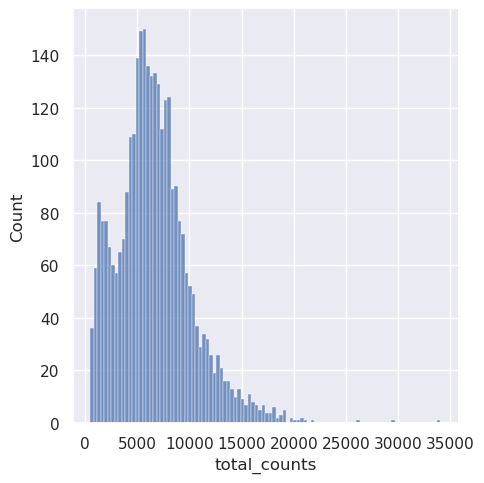

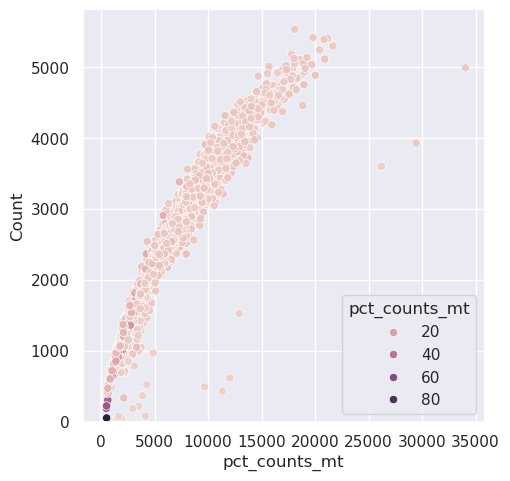

In [14]:
sns.displot(ETV6_RUNX1_1.obs, x="total_counts", bins=100)
sns.displot(ETV6_RUNX1_1.obs, x="pct_counts_mt", bins=100)
sns.scatterplot(ETV6_RUNX1_1.obs, x="total_counts", y="n_genes_by_counts", hue="pct_counts_mt")

Alternatively, we can use `scanpy`'s own plotting functions (histogram is not available, but we can do violin plots instead):  

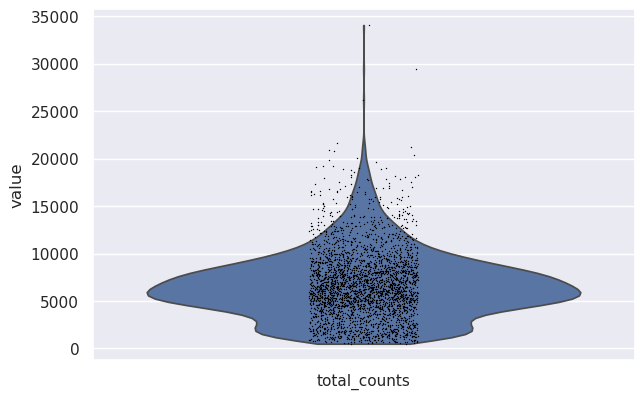

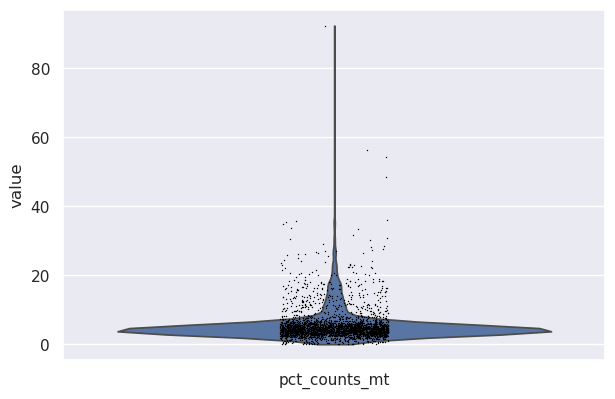

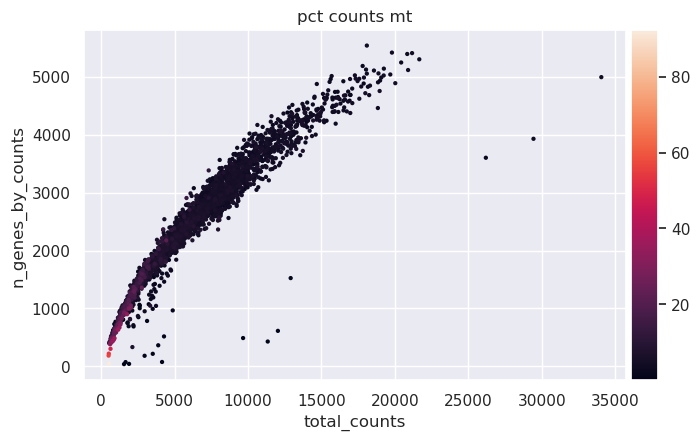

In [15]:
sc.pl.violin(ETV6_RUNX1_1, "total_counts")
sc.pl.violin(ETV6_RUNX1_1, "pct_counts_mt")
sc.pl.scatter(ETV6_RUNX1_1, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

We can even do several violin plots at once: 

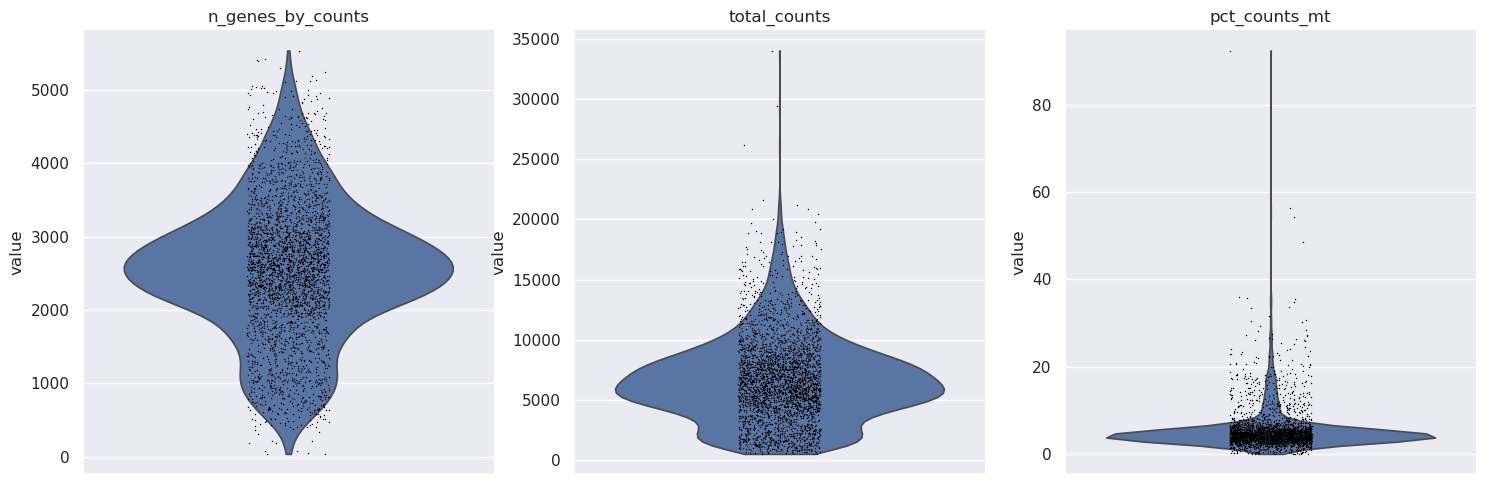

In [16]:
sc.pl.violin(
  ETV6_RUNX1_1,
  ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
  multi_panel=True
)

We can filter our object based on hard thresholds set manually. 
Alternatively, we can define a function that removes outliers based on the observed distribution:

In [17]:
def is_outlier(adata, metric: str, nmads: int):
  M = adata.obs[metric]
  
  outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
      np.median(M) + nmads * median_abs_deviation(M) < M
  )
  return outlier

The function returns `True` or `False` depending on whether the value exceeds the specified value of median absolute deviation. 
For example: 

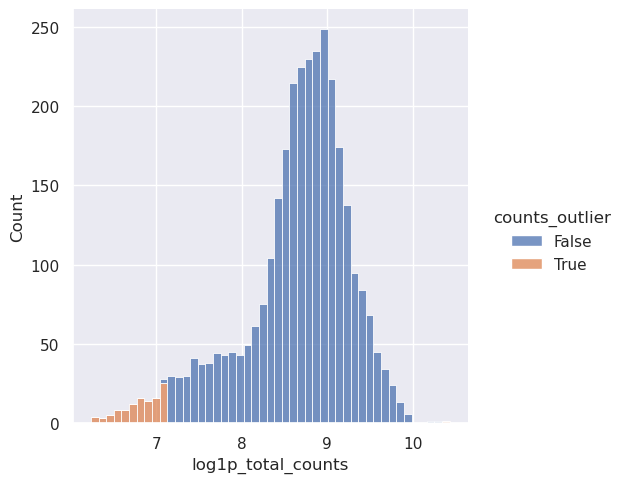

In [18]:
# create barcode metadata column indicating counts outliers
ETV6_RUNX1_1.obs["counts_outlier"] = is_outlier(ETV6_RUNX1_1, "log1p_total_counts", 5)

# visualise
sns.displot(ETV6_RUNX1_1.obs, x="log1p_total_counts", hue="counts_outlier", multiple="stack")

Note that we used the log-transformed counts, as its distribution is less skewed and therefore more suitable for the MAD-based filtering we are doing.  

We can repeat this for number of detected genes (also log-transformed) and the percentage of counts in the top 20 genes:

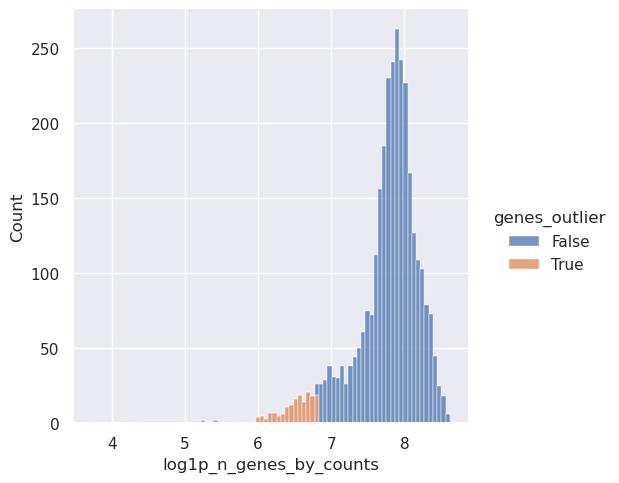

In [19]:
ETV6_RUNX1_1.obs["genes_outlier"] = is_outlier(ETV6_RUNX1_1, "log1p_n_genes_by_counts", 5)
sns.displot(ETV6_RUNX1_1.obs, x="log1p_n_genes_by_counts", hue="genes_outlier", multiple="stack")

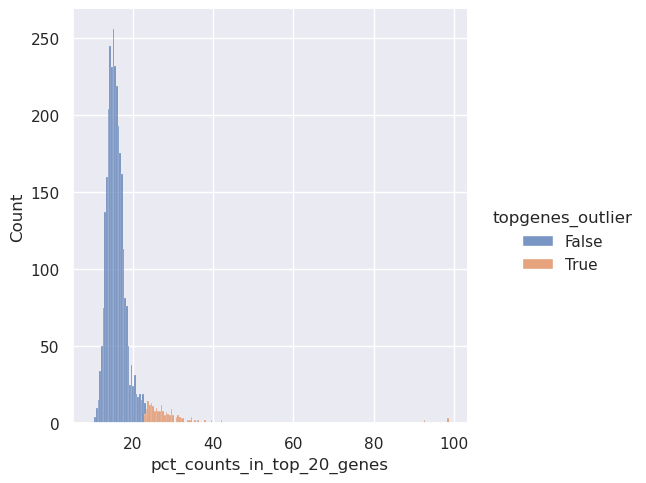

In [20]:
ETV6_RUNX1_1.obs["topgenes_outlier"] = is_outlier(ETV6_RUNX1_1, "pct_counts_in_top_20_genes", 5)
sns.displot(ETV6_RUNX1_1.obs, x="pct_counts_in_top_20_genes", hue="topgenes_outlier", multiple="stack")

We also check for outliers with regards to percentage of mitochondrial counts, where we use more strict filters: 

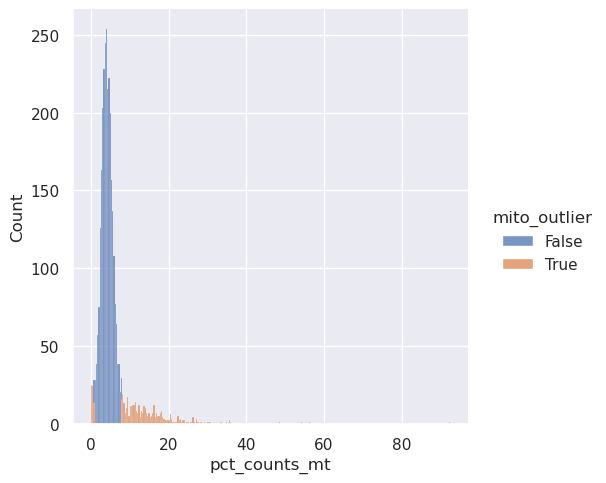

In [21]:
ETV6_RUNX1_1.obs["mito_outlier"] = is_outlier(ETV6_RUNX1_1, "pct_counts_mt", 3) | (ETV6_RUNX1_1.obs["pct_counts_mt"] > 8)
sns.displot(ETV6_RUNX1_1.obs, x="pct_counts_mt", hue="mito_outlier", multiple="stack")

Finally, we create a variable which is the union of these conditions, i.e. if the barcode is determined an outlier of _any_ of our filters, then we consider it to be an outlier: 

In [22]:
ETV6_RUNX1_1.obs["outlier"] = ETV6_RUNX1_1.obs["genes_outlier"] | ETV6_RUNX1_1.obs["genes_outlier"] | ETV6_RUNX1_1.obs["topgenes_outlier"] | ETV6_RUNX1_1.obs["mito_outlier"]

ETV6_RUNX1_1.obs["outlier"].value_counts()

outlier
False    2674
True      479
Name: count, dtype: int64

We can visualise our scatterplot of counts vs detected genes to see which barcodes will be removed: 

<Axes: xlabel='total_counts', ylabel='n_genes_by_counts'>

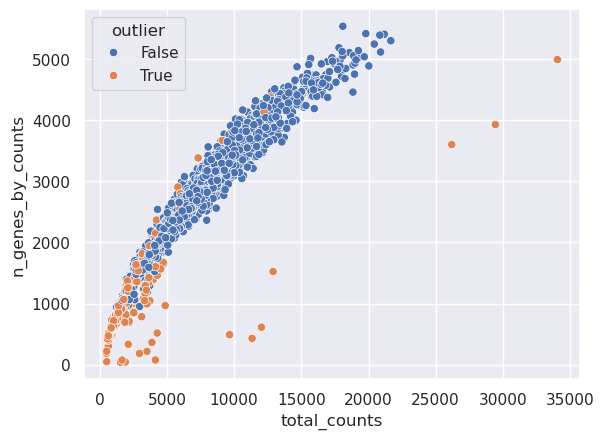

In [23]:
sns.scatterplot(ETV6_RUNX1_1.obs, 
                x = "total_counts", 
                y = "n_genes_by_counts",
                hue = "outlier")

In [24]:
ETV6_RUNX1_1 = ETV6_RUNX1_1[~ETV6_RUNX1_1.obs["outlier"], :].copy()

The barcodes we are left with after this filtering we will now consider to be cells. 

### 4.2 Filtering Genes

In the same way that we explored several metrics for barcodes, we can also explore them for genes. However, as we will see, downstream analysis can focus on variable genes and will mostly ignore genes for which there is very little data. Therefore, we don't perform as strict filtering on genes as we do on barcodes.    

Still, it is useful to remove undetected genes, i.e. those with zero total counts:

In [25]:
# count of genes with zero counts
ETV6_RUNX1_1.var["total_counts"].eq(0).value_counts()

total_counts
False    26377
True     11189
Name: count, dtype: int64

We can use the `sc.pp.filter_genes()` function to do this:  

In [26]:
sc.pp.filter_genes(ETV6_RUNX1_1, min_counts=0)

# check number  of genes left
ETV6_RUNX1_1.n_vars

37566

### 4.3 Removal of doublets

In [27]:
ETV6_RUNX1_1.obs.keys()

Index(['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'counts_outlier',
       'genes_outlier', 'topgenes_outlier', 'mito_outlier', 'outlier'],
      dtype='object')

In [28]:
sc.pp.scrublet(ETV6_RUNX1_1)

In [29]:
ETV6_RUNX1_1.obs.keys()

Index(['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'counts_outlier',
       'genes_outlier', 'topgenes_outlier', 'mito_outlier', 'outlier',
       'doublet_score', 'predicted_doublet'],
      dtype='object')

"We can remove doublets by either filtering out the cells called as doublets, or waiting until we’ve done a clustering pass and filtering out any clusters with high doublet scores."  
https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html 

In [30]:
ETV6_RUNX1_1.obs["predicted_doublet"].value_counts()

predicted_doublet
False    2663
True       11
Name: count, dtype: int64

In [31]:
ETV6_RUNX1_1.shape

(2674, 37566)

In [32]:
ETV6_RUNX1_1 = ETV6_RUNX1_1[~ETV6_RUNX1_1.obs["predicted_doublet"], :].copy()
ETV6_RUNX1_1.shape

(2663, 37566)

<a id="normalisation"></a>
## 4. Normalisation

There are several normalisation methods available for single-cell RNA-seq data. Two of those methods are:  

- **Pearson residuals:** this method models the count data using a negative binomial regression model to regress out the effects of total count differences between cells and uses the residuals from the model as the normalised count values.  
- **Shifted logarithm:** scales the counts by a cell-specific size factor (based on the total counts in that cell) followed by taking its logarithm. Despite being a relatively simple method, it has been shown to perform well in downstream analysis such as dimensionality reduction and clustering.  

We will use the `layers` component of the AnnData object, which can be used to store different versions of our count matrix.  This is a good way to keep several versions of our data in place, especially as we explore different methods of normalisation.

In [33]:
# keep a copy of the raw counts in the object as a backup
ETV6_RUNX1_1.layers["counts"] = ETV6_RUNX1_1.X.copy()

# create a new layer for Pearson residuals
ETV6_RUNX1_1.layers["pearson"] = ETV6_RUNX1_1.X.copy()
sc.experimental.pp.normalize_pearson_residuals(ETV6_RUNX1_1, layer="pearson")
# convert to sparse matrix (efficient and saves memory)
ETV6_RUNX1_1.layers["pearson"] = csr_matrix(ETV6_RUNX1_1.layers["pearson"])

# create new layer for log-normalised counts
ETV6_RUNX1_1.layers["logcounts"] = ETV6_RUNX1_1.X.copy()
sc.pp.normalize_total(ETV6_RUNX1_1, layer="logcounts", target_sum=None)
sc.pp.log1p(ETV6_RUNX1_1, layer="logcounts")

/opt/conda/lib/python3.10/site-packages/scanpy/experimental/pp/_normalization.py:68: RuntimeWarning: invalid value encountered in divide
  residuals = diff / np.sqrt(mu + mu**2 / theta)


We can visualise the distributions and correlations of the normalised data as a pair plot:

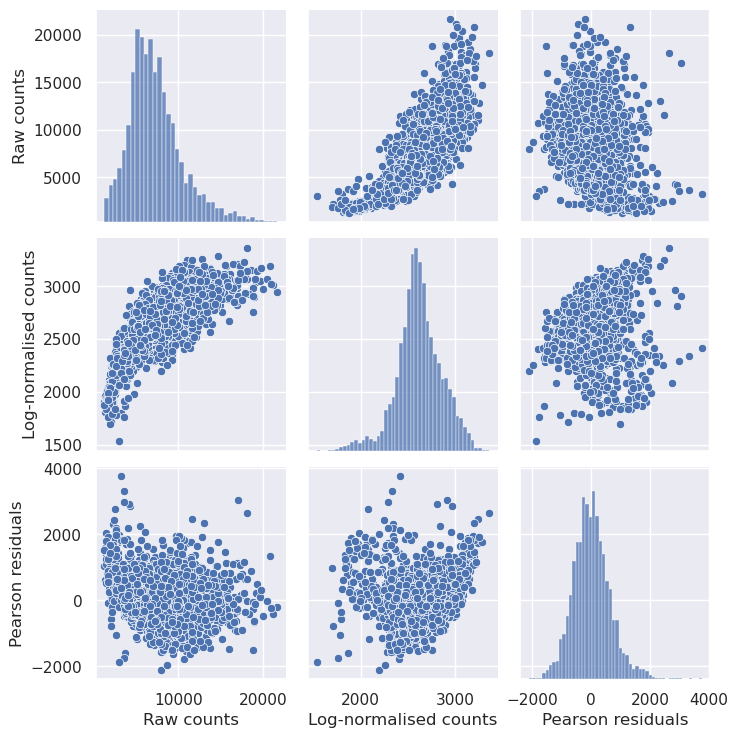

In [34]:
# note: np.nansum() only works in regular matrix, so we coerce from the sparse matrix format
sns.pairplot(
  pd.DataFrame({"Raw counts": np.nansum(ETV6_RUNX1_1.layers["counts"].toarray(), 1),
              "Log-normalised counts": np.nansum(ETV6_RUNX1_1.layers["logcounts"].toarray(), 1),
              "Pearson residuals": np.nansum(ETV6_RUNX1_1.layers["pearson"].toarray(), 1)})
)

As we can see, while the log-normalised data is fairly well correlated with the original counts, the Pearson residuals are not. This is because the Pearson residuals represent the output of a model taking into account the total counts of the cell, thus the values represent whether the expression is above or below the expected value of expression for that gene.  

There is no "right method" when it comes to normalisation, and often several methods should be explored, alongside a knowledge of the biology. The Pearson residuals normalisation is argued to capture more of the relevant biological signal ([Lause et al. 2021](https://doi.org/10.1186/s13059-021-02451-7)) and the [Scanpy documentation](https://scanpy.readthedocs.io/en/stable/tutorials/experimental/pearson_residuals.html) gives details about using this normalisation for downstream analysis.  

However, as this method is computationally more demanding, we will proceed with the log normalisation. 

<a id="workflow"></a>
## 5. Preprocessing workflow

Now that we have explored these things with a single sample, we can bring it all together to process all our samples. We will define a function that performs the preprocessing steps covered:  

* Read the CellRanger matrix
* Add gene annotation
* Filter barcodes based on different metrics
* Normalise the counts (using the simpler log-normalisation)

In [35]:
# def qc(adata):
#     # Generate qc metrics
#     adata.var["mt"] = adata.var["chrom"] == "MT"
#     sc.pp.calculate_qc_metrics(
#         adata, 
#         qc_vars=["mt"], 
#         inplace=True, percent_top=[20], 
#         log1p=True
#         )
    
#     # Identify outliers per qc metric
#     adata.obs["counts_outlier"] = is_outlier(adata, "log1p_total_counts", 5)
#     adata.obs["genes_outlier"] = is_outlier(adata, "log1p_n_genes_by_counts", 5)
#     adata.obs["topgenes_outlier"] = is_outlier(adata, "pct_counts_in_top_20_genes", 5)
#     adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (adata.obs["pct_counts_mt"] > 8)

#     # Identify outliers based on ALL qc metrics 
#     adata.obs["outlier"] = (
#         adata.obs["counts_outlier"]  
#         | adata.obs["genes_outlier"] 
#         | adata.obs["topgenes_outlier"] 
#         | adata.obs["mt_outlier"]
#     )
#     # Remove outliers
#     adata = adata[~adata.obs["outlier"]].copy()
    
#     return(adata)
    
def sc_preprocess(path: str, gene_annot: pd.DataFrame):
    
    print("1. Reading data matrix")
    adata = sc.read_10x_mtx(path)
    
    print("2. Adding gene metadata")
    gene_annot = adata.var.merge(gene_annot, how="left", on="gene_ids")
    gene_annot.set_index(adata.var.index, inplace=True)
    
    if (adata.var["gene_ids"] == gene_annot["gene_ids"]).all():
        adata.var = gene_annot
    else: 
        print("The gene order was not the same!")
        return
    
    vars_to_keep = adata.var["chrom"].isin([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])
    adata = adata[:, vars_to_keep].copy()

    adata.var["mt"] = adata.var["chrom"] == "MT"

    print("3. Calculating QC metrics and filtering")
    # Generate qc metrics
    sc.pp.calculate_qc_metrics(
        adata, 
        qc_vars=["mt"], 
        inplace=True, percent_top=[20], 
        log1p=True
        )
    
    # Identify outliers per qc metric
    adata.obs["counts_outlier"] = is_outlier(adata, "log1p_total_counts", 5)
    adata.obs["genes_outlier"] = is_outlier(adata, "log1p_n_genes_by_counts", 5)
    adata.obs["topgenes_outlier"] = is_outlier(adata, "pct_counts_in_top_20_genes", 5)
    adata.obs["mito_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (adata.obs["pct_counts_mt"] > 8)

    # Identify outliers based on ALL qc metrics 
    adata.obs["outlier"] = (
        adata.obs["counts_outlier"]  
        | adata.obs["genes_outlier"] 
        | adata.obs["topgenes_outlier"] 
        | adata.obs["mito_outlier"]
    )
    # Remove outliers
    adata = adata[~adata.obs["outlier"]].copy()

    # Perform gene filtering
    sc.pp.filter_genes(adata, min_cells=1)

    # Remove doublets
    sc.pp.scrublet(adata)
    adata = adata[~adata.obs["predicted_doublet"], :].copy()

    print("4. Applying normalisations")
    adata.layers["counts"] = adata.X.copy()

    sc.pp.normalize_total(adata, target_sum=None)
    sc.pp.log1p(adata)

    return adata

# our outlier detection function from before
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
            np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

We apply this function to each of our samples, looping through each of them based on our sample information DataFrame: 

In [36]:
sample_info = pd.read_table("../Data/sample_sheet.tsv")
sample_info = sample_info.rename(columns={"Sample": "sample_id", 
                                          "SampleName": "sample_name", 
                                          "SampleGroup": "sample_group"})
sample_info

,sample_id,sample_name,sample_group
0,SRR9264343,ETV6-RUNX1_1,ETV6-RUNX1
1,SRR9264344,ETV6-RUNX1_2,ETV6-RUNX1
2,SRR9264345,ETV6-RUNX1_3,ETV6-RUNX1
3,SRR9264346,ETV6-RUNX1_4,ETV6-RUNX1
4,SRR9264347,HHD_1,HHD
5,SRR9264348,HHD_2,HHD
6,SRR9264349,PRE-T_1,PRE-T
7,SRR9264350,PRE-T_2,PRE-T
8,SRR9264351,PBMMC_1,PBMMC
9,SRR9264353,PBMMC_2,PBMMC


To make it doable computationally, we restrict things to a few samples only: 

In [37]:
# create a dictionary to hold all AnnData objects
adata = dict.fromkeys(sample_info["sample_id"])

# read all samples
for sample in adata.keys():
  print(f"\nReading {sample}")
  adata[sample] = sc_preprocess(
    f"../Data/CellRanger_Outputs/{sample}/outs/filtered_feature_bc_matrix/",
    h38_genes
    )


Reading SRR9264343
1. Reading data matrix
2. Adding gene metadata
3. Calculating QC metrics and filtercing
4. Applying normalisations

Reading SRR9264344
1. Reading data matrix
2. Adding gene metadata
3. Calculating QC metrics and filtercing
4. Applying normalisations

Reading SRR9264345
1. Reading data matrix
2. Adding gene metadata
3. Calculating QC metrics and filtercing
4. Applying normalisations

Reading SRR9264346
1. Reading data matrix
2. Adding gene metadata
3. Calculating QC metrics and filtercing
4. Applying normalisations

Reading SRR9264347
1. Reading data matrix
2. Adding gene metadata
3. Calculating QC metrics and filtercing
4. Applying normalisations

Reading SRR9264348
1. Reading data matrix
2. Adding gene metadata
3. Calculating QC metrics and filtercing
4. Applying normalisations

Reading SRR9264349
1. Reading data matrix
2. Adding gene metadata
3. Calculating QC metrics and filtercing
4. Applying normalisations

Reading SRR9264350
1. Reading data matrix
2. Adding ge

Our next step is to combine all these separate objects into a single AnnData object, with information about the sample that each barcode comes from.  

Before doing that, we will grab the gene metadata, which unfortunately gets lost when combining multiple AnnData objects (see [this post](https://discourse.scverse.org/t/loosing-anndata-var-layer-when-using-sc-concat/1605) for details).

In [38]:
# grab all var DataFrames from our dictionary
all_var = [x.var for x in adata.values()]
# concatenate them
all_var = pd.concat(all_var, join="outer")
# we keep only some columns of interest
all_var = all_var[["gene_ids", "gene_name", "chrom"]]
# remove duplicates
all_var = all_var[~all_var.duplicated()]

Now we have all the gene metadata, we proceed with combining all these objects together using scanpy's concatenation function:

In [39]:
adata = sc.concat(adata, join="outer", label="sample_id", index_unique="-")

After concatenation, we can add back the gene metadata that we collected earlier: 

In [40]:
adata.var = all_var.loc[adata.var_names]

And we add the information about our samples to the cells' metadata:

In [41]:
adata.obs = (
  adata.obs
  .merge(sample_info, how="left", on="sample_id")
  .set_axis(adata.obs.index)
)

Note we used `.set_axis(adata.obs.index)` to ensure we retained the rowname indexes of the table as the original (i.e. the barcode names). If we don't do this, it will generate an invalid anndata object.  

Finally, with the full data merged, we save this object for downstream analysis: 

In [42]:
adata.write("../Data/results/04_05/caron_filtered_full.h5ad")

We are now ready to perform downstream analyses.